# Arbol de Decisión

In [1]:
import matplotlib
from preprocessing import *
from aux import *
np.warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier, plot_tree

sns.set()

df_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1i-KJ2lSvM7OQH0Yd59bX01VoZcq8Sglq')
df_decision = pd.read_csv('https://drive.google.com/uc?export=download&id=1km-AEIMnWVGqMtK-W28n59hqS5Kufhd0')

## Preprocesado 1

In [2]:
def preprocesado_1(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = crear_feature_acompañantes(df)
    df = replace_nulls_column(df, 'edad', 'media')
    df = normalizar_atributos_numericos(df)
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [3]:
columnillas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan', 
              'cant_acompañantes']

In [4]:
volver = ['volveria']
columnas = columnillas + volver

In [5]:
dataset = pd.merge(df_data, df_decision, how='inner', left_on='id_usuario', right_on='id_usuario')

df = preprocesado_1(dataset, columnas)

df.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes,volveria
0,1,0,0,0.130337,0,0,0.880653,0.000,0.000000,0.000000,0,1,0,0.0,0.0
1,1,0,0,0.738202,1,0,0.396985,0.125,0.166667,0.020408,0,1,0,0.2,0.0
2,0,1,0,0.891011,0,0,0.368090,0.000,0.000000,0.040816,0,0,0,0.0,0.0
3,1,0,0,0.510112,0,0,0.368090,0.000,0.000000,0.000000,1,0,0,0.0,0.0
4,1,0,0,0.193258,1,0,0.007538,0.125,0.166667,0.020408,1,0,0,0.2,1.0


In [6]:
df.shape

(801, 15)

# Entrenamiento

X.shape:  (801, 14)
y.shape:  (801,) 



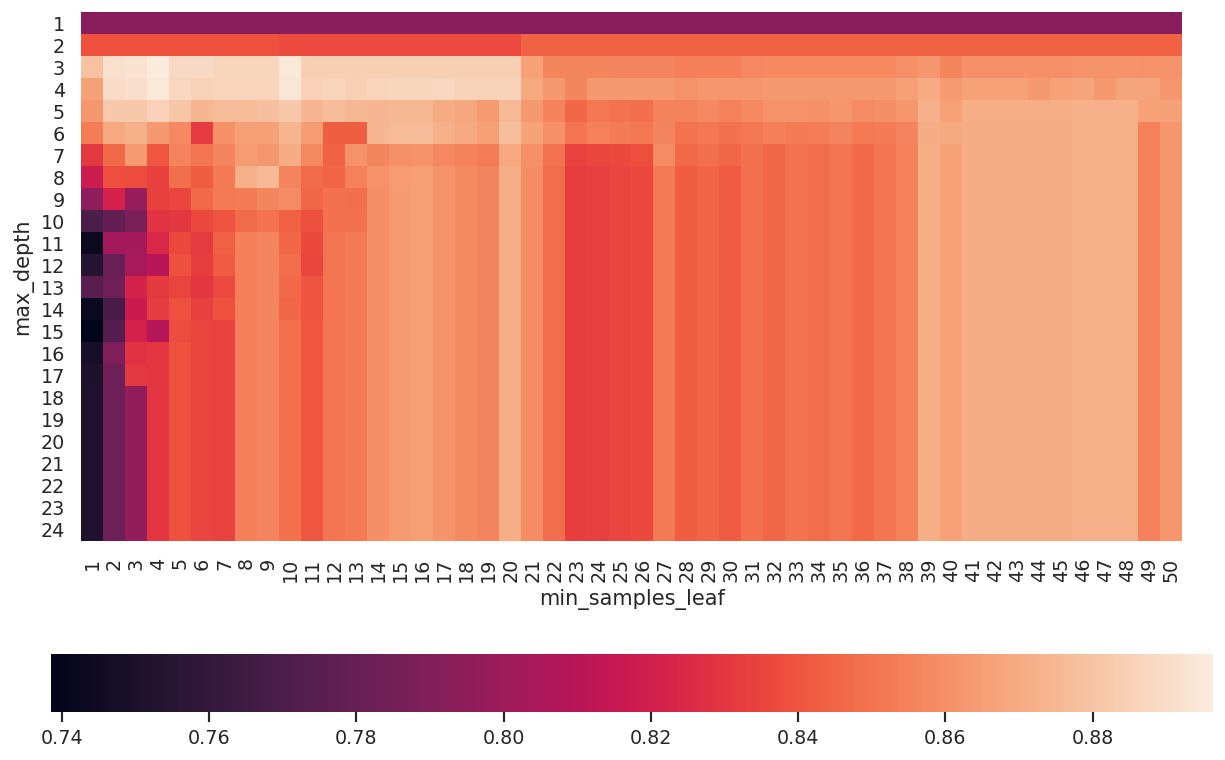

In [7]:
def split_dataset_test_and_train (df, df_columns):
    X = df.loc[:, df_columns]
    y = df.loc[:, 'volveria']
    print("X.shape: ", X.shape)
    print("y.shape: ", y.shape, "\n")
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117)
    return X_train, X_test, y_train, y_test


def params_search_for_decision_tree (X_train, X_test, y_train, y_test):
    max_depths = np.arange(1, 25)
    min_samples_leafs = np.arange(1, 51)
    data_points = []
    for max_depth in max_depths:
        for min_samples_leaf in min_samples_leafs:
            clf = DecisionTreeClassifier(
                max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=117
            )
            clf.fit(X_train, y_train)
            data_points.append((max_depth, min_samples_leaf, roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]),))

    data_points = pd.DataFrame(
        data_points, columns=["max_depth", "min_samples_leaf", "score"]
    )
    return data_points


def find_params_for_decision_tree (X_train, X_test, y_train, y_test):
    data_points = params_search_for_decision_tree(X_train, X_test, y_train, y_test)
    plt.figure(dpi=125, figsize=(12, 8))
    g = sns.heatmap(data_points.pivot_table(index="max_depth", columns="min_samples_leaf", values="score"),
                    square=True,cbar_kws=dict(use_gridspec=False, location="bottom"),)

X_train, X_test, y_train, y_test = split_dataset_test_and_train(df, columnillas)    
find_params_for_decision_tree(X_train, X_test, y_train, y_test)

# Baseline

Entrenamos el modelo considerando parámetros que nos parecen razonables, en base al plot

In [8]:
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=117)
clf.fit(X_train, y_train)
X = df.loc[:, columnillas]
y = df.loc[:, 'volveria']  
arbol = apply_stratified_k_fold(X,y,clf)

Fold 0: AUC ROC score is 0.7357
Fold 1: AUC ROC score is 0.7994
Fold 2: AUC ROC score is 0.8637
Fold 3: AUC ROC score is 0.7856
Fold 4: AUC ROC score is 0.7796
Mean test AUC ROC is: 0.7928


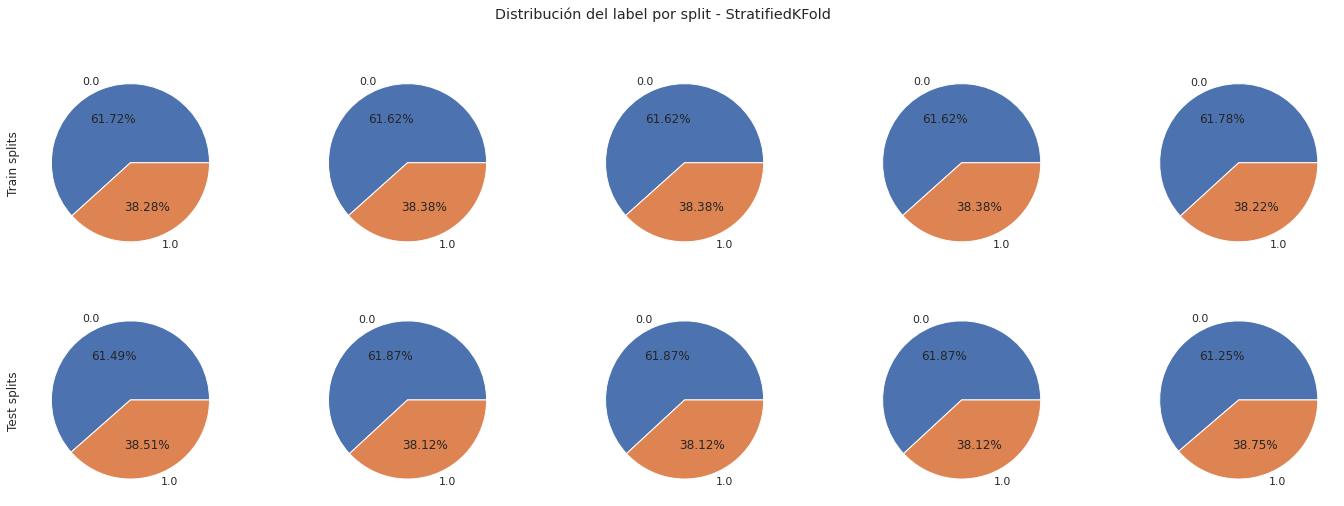

In [9]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(24, 8), sharey=True)

kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    pd.Series(y[train_index]).value_counts(normalize=True).plot(
        kind='pie', autopct="%.2f%%", ax=axes[0][fold_idx]
    )
    pd.Series(y[test_index]).value_counts(normalize=True).plot(
        kind='pie', autopct="%.2f%%", ax=axes[1][fold_idx]
    )

axes[0][0].set_ylabel("Train splits")
axes[1][0].set_ylabel("Test splits")
plt.suptitle("Distribución del label por split - StratifiedKFold")

plt.show()

# Métricas

In [10]:
scores = get_scores(arbol, X_test, y_test)

AUC ROC : 0.8906
Accuracy : 0.8557
Precision : 0.8261
Recall : 0.9055
F1-Score : 0.7972


## Matriz de confusión

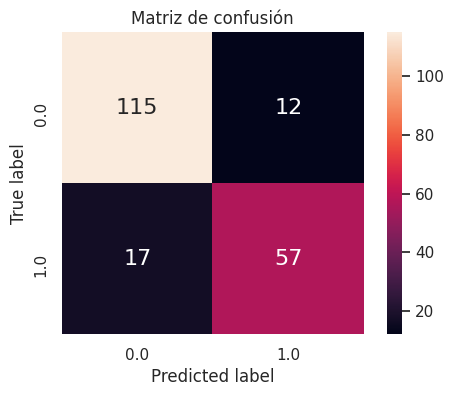

In [11]:
plot_confusion_matrix(y_test, arbol.predict(X_test))

## Viendo el modelo

Dado que obtuvimos un 86% de accuracy y un 81% con Stratified K fold, no está demás imprimir el arbol para ver cómo decide

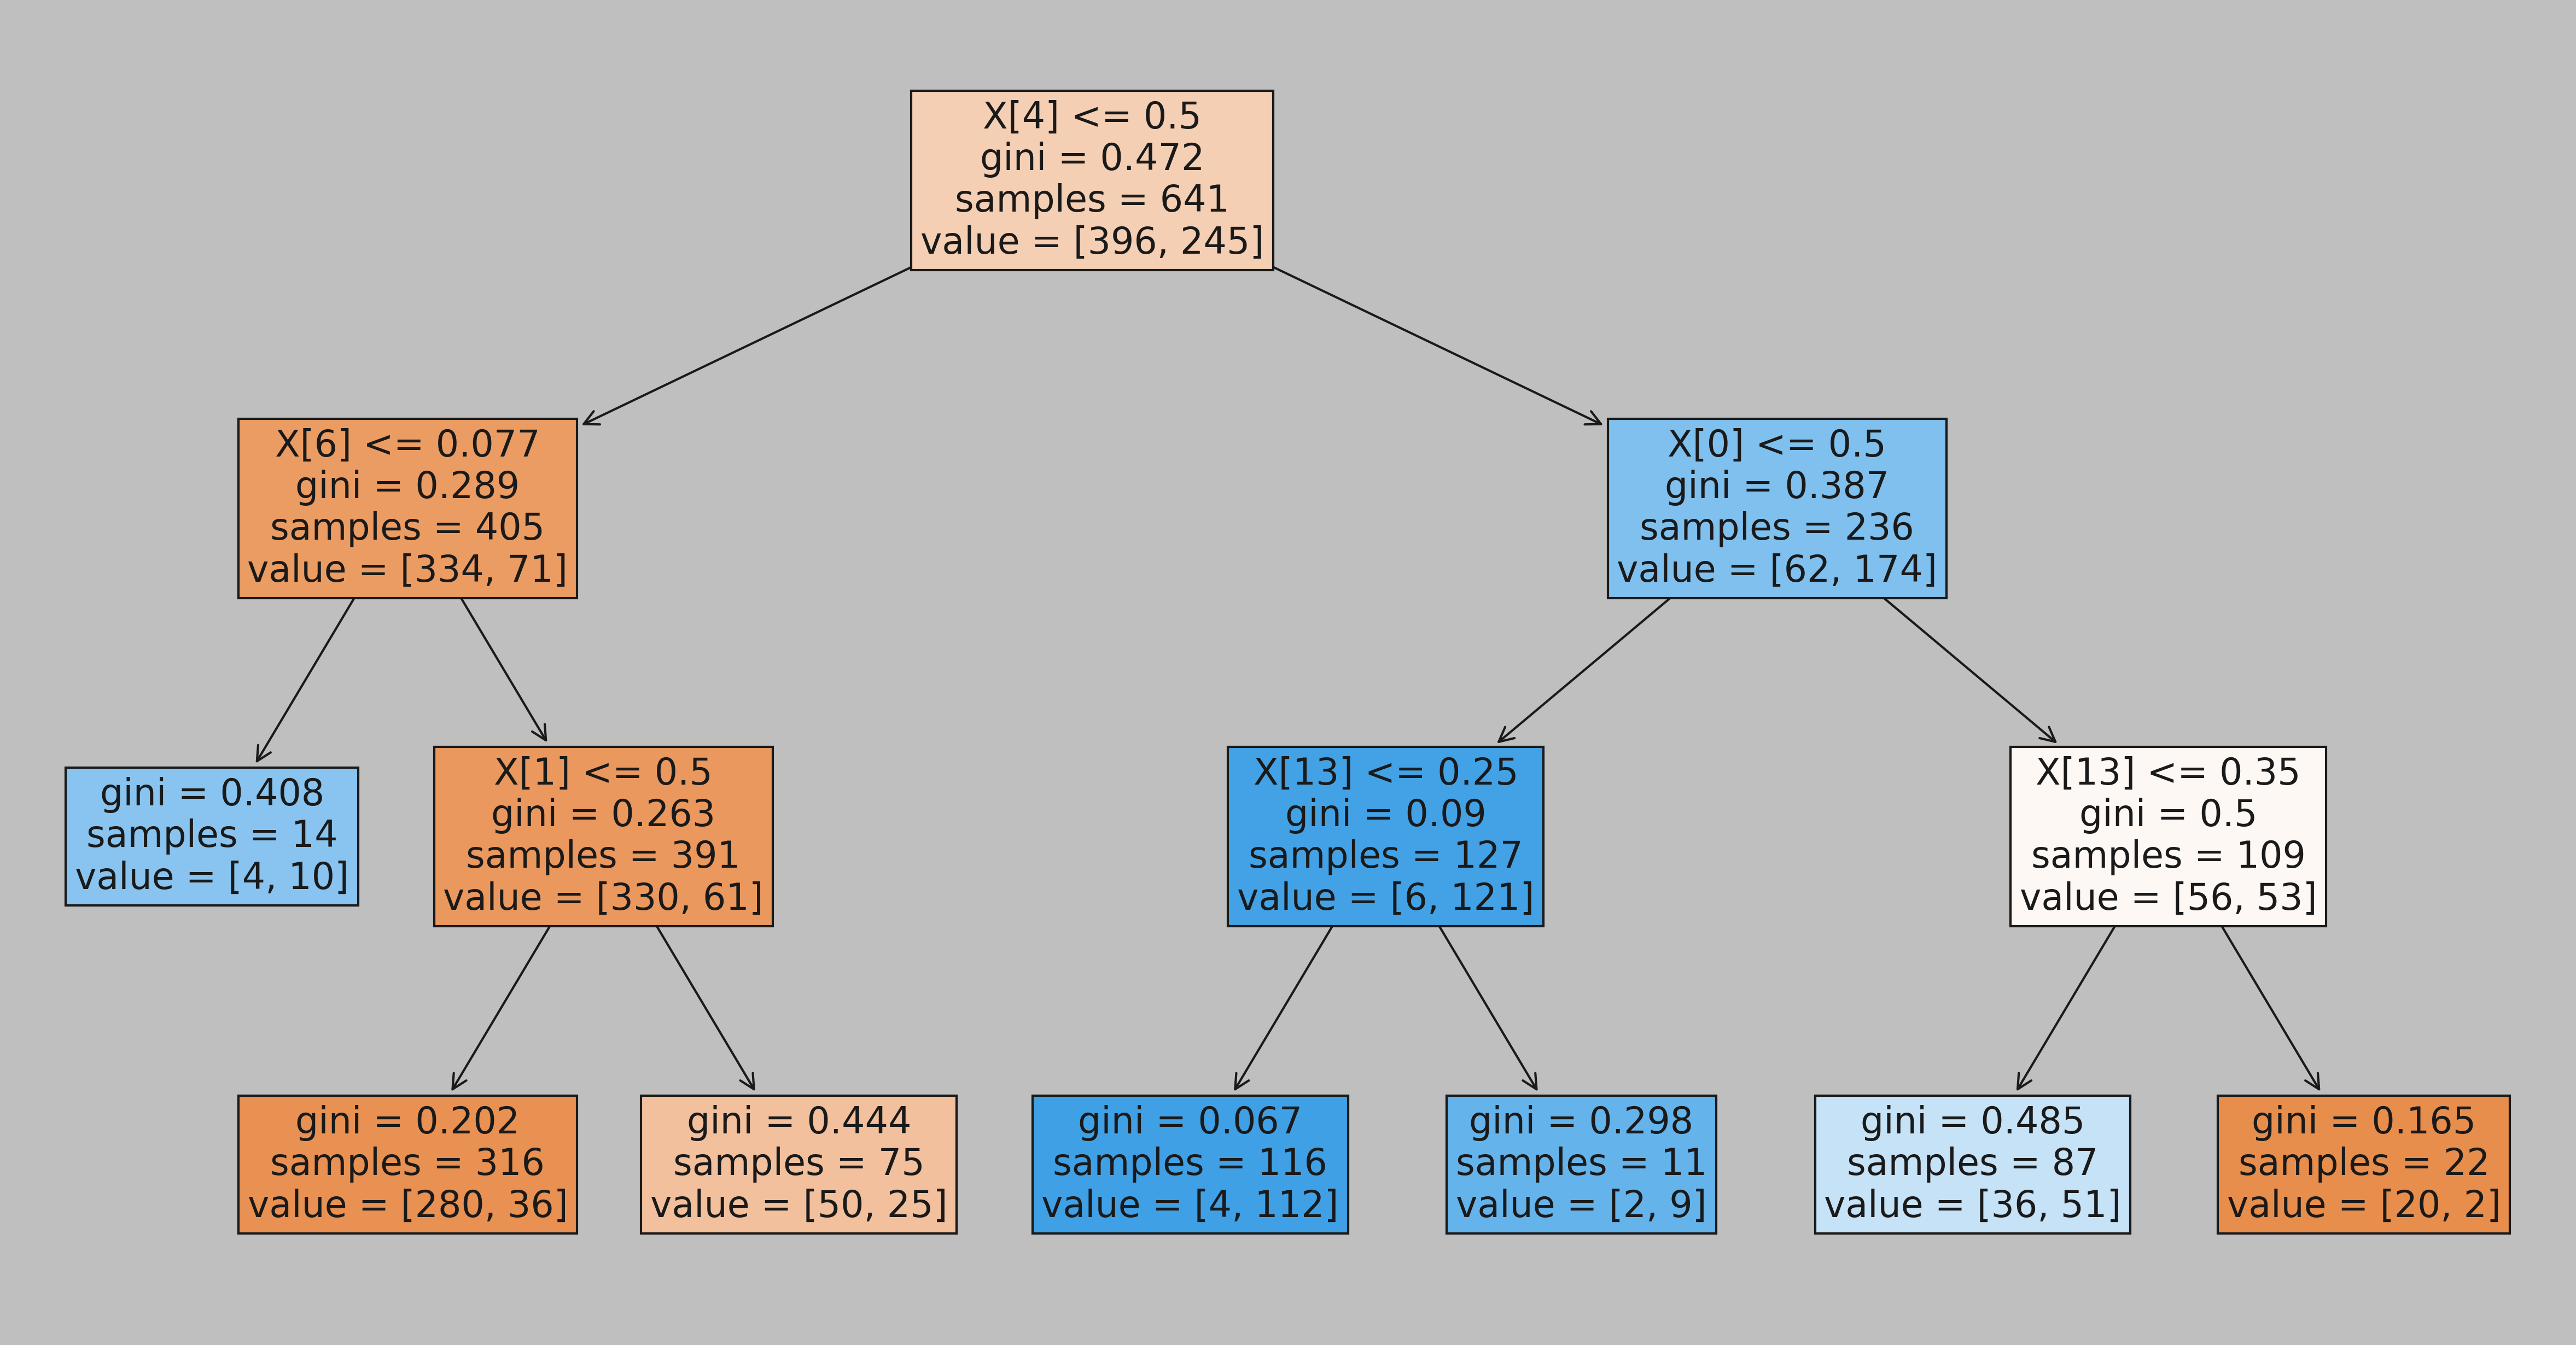

In [12]:
with plt.style.context("classic"):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=300)
    plot_tree(arbol, filled=True, fontsize=16)

# Test Holdout

Por último, para validar contra datos nunca vistos, usamos un conjunto de holdout.

En este caso, y para todos los modelos de este TP, es un nuevo archivo para el que no poseemos los valores a predecir

In [13]:
holdout = pd.read_csv('https://drive.google.com/uc?export=download&id=1I980-_K9iOucJO26SG5_M8RELOQ5VB6A')

In [14]:
df_h = preprocesado_1(holdout, columnillas)
df_h.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,cant_acompañantes
0,1,0,0,0.751756,1,0,0.344774,0.0,0.0,0.000000,1,0,0,0.0
1,1,0,0,0.264637,1,0,0.063963,0.5,0.4,0.061224,1,0,0,0.6
2,0,1,0,0.026932,0,0,0.609984,0.0,0.0,0.040816,0,0,0,0.0
3,0,0,0,0.637002,0,0,0.407176,0.0,0.0,0.040816,1,0,0,0.0
4,1,0,0,0.471897,0,0,0.450858,0.0,0.0,0.000000,1,0,0,0.0


In [15]:
df_resultado = evaluate_holdout(holdout, df_h, arbol)
df_resultado.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 14) 



,id_usuario,volveria
0,650,1
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [16]:
df_resultado.to_csv('prediccion/arbol_resultado_final.csv')

## Preprocesado 2

In [17]:
def preprocesado_2(dataset, columnas):
    df = eliminar_features_que_no_aportan_info(dataset, True)
    df = replace_nulls_column(df, 'edad', 'mediana')
    df = encodear_atributos_categoricos(df)
    df = df.reindex(columns = columnas)
    return df

In [18]:
columnas_nuevas = ['tipo_de_sala_4d', 'tipo_de_sala_normal', 'tipo_de_sala_nan', 'id_usuario', 'genero_mujer', 'genero_nan', 
              'edad', 'amigos', 'parientes', 'precio_ticket', 
              'nombre_sede_fiumark_palermo', 'nombre_sede_fiumark_quilmes', 'nombre_sede_nan']
columnas_2 = columnas_nuevas + volver

In [19]:
df_2 = preprocesado_2(dataset, columnas_2)
df_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan,volveria
0,1,0,0,117,0,0,73.5,0,0,1,0,1,0,0
1,1,0,0,658,1,0,35.0,1,1,2,0,1,0,0
2,0,1,0,794,0,0,31.0,0,0,3,0,0,0,0
3,1,0,0,455,0,0,31.0,0,0,1,1,0,0,0
4,1,0,0,173,1,0,4.0,1,1,2,1,0,0,1


In [20]:
df_2.shape

(801, 14)

X.shape:  (801, 13)
y.shape:  (801,) 



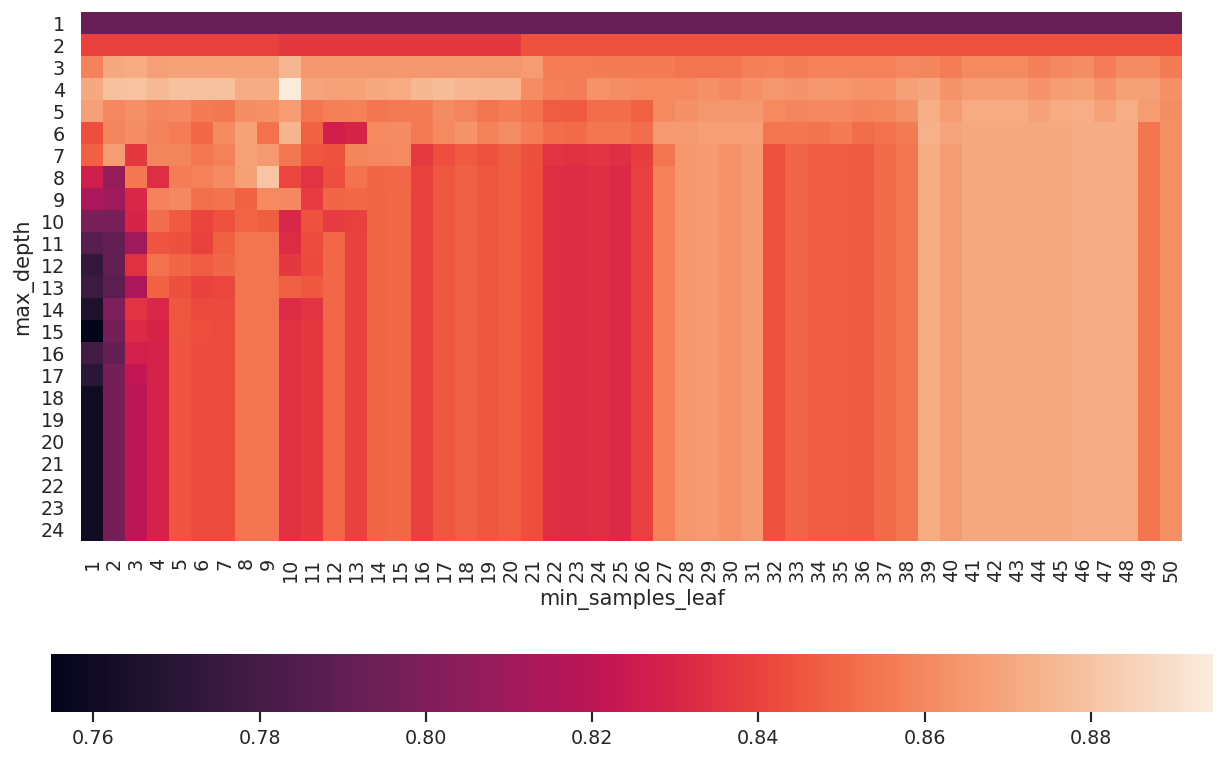

In [25]:
X_train_2, X_test_2, y_train_2, y_test_2 = split_dataset_test_and_train(df_2, columnas_nuevas)    
find_params_for_decision_tree(X_train_2, X_test_2, y_train_2, y_test_2)

In [26]:
min_samples_leaf_best = 10
max_depth_best = 4
clf_2 = DecisionTreeClassifier(max_depth=max_depth_best, min_samples_leaf=min_samples_leaf_best, random_state=117)
clf_2.fit(X_train_2, y_train_2)
X_2 = df_2.loc[:, columnas_nuevas]
y_2 = df_2.loc[:, 'volveria']
arbol_2 = apply_stratified_k_fold(X_2,y_2,clf_2)

Fold 0: AUC ROC score is 0.7479
Fold 1: AUC ROC score is 0.7830
Fold 2: AUC ROC score is 0.8152
Fold 3: AUC ROC score is 0.7805
Fold 4: AUC ROC score is 0.7686
Mean test AUC ROC is: 0.7790


## Métricas

In [27]:
scores_2 = get_scores(arbol_2, X_test_2, y_test_2)

AUC ROC : 0.8957
Accuracy : 0.8507
Precision : 0.8235
Recall : 0.9055
F1-Score : 0.7887


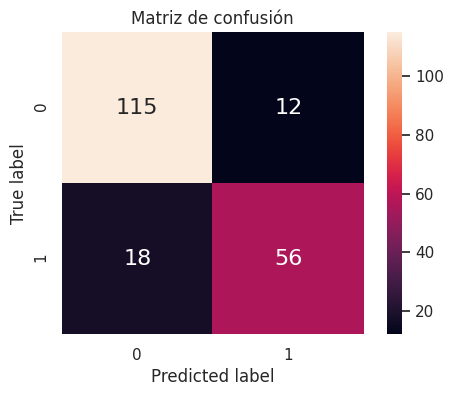

In [28]:
plot_confusion_matrix(y_test_2, arbol_2.predict(X_test_2))

# Segundo Holdout

In [34]:
df_h_2 = preprocesado_2(holdout, columnas_nuevas)
df_h_2.head()

,tipo_de_sala_4d,tipo_de_sala_normal,tipo_de_sala_nan,id_usuario,genero_mujer,genero_nan,edad,amigos,parientes,precio_ticket,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,1,0,0,650,1,0,26.0,0,0,1,1,0,0
1,1,0,0,234,1,0,8.0,4,2,4,1,0,0
2,0,1,0,31,0,0,43.0,0,0,3,0,0,0
3,0,0,0,552,0,0,30.0,0,0,3,1,0,0
4,1,0,0,411,0,0,32.0,0,0,1,1,0,0


In [35]:
df_resultado_2 = evaluate_holdout(holdout,df_h_2, arbol_2)
df_resultado_2.head(15)

y_pred.shape:  (90,)
holdout_df.shape:  (90, 13) 



,id_usuario,volveria
0,650,1
1,234,0
2,31,0
3,552,0
4,411,0
5,134,1
6,497,1
7,434,0
8,528,0
9,112,1


In [36]:
df_resultado_2.to_csv('prediccion/arbol_2do_prepoc_resultado_final.csv')